### Following EDA - Major topics

As we have seen earlier, working on the whole dataset leads the kernel to crash on local machine.
So we are working on a sample of the dataframe to enable calculation of vocabulary.

In [5]:
#Load usual libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
import pandas as pd
df = pd.read_csv('./data/abcnews-date-text.csv')
df.head(5)

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [4]:
#Converting dates to datetime format easier to handle
df.publish_date =  pd.to_datetime(df.publish_date.apply(lambda x: str(x)), format='%Y%m%d')

### Sampling

In [1]:
df_samp = df.sample(frac=0.10, random_state=23) # retaining 10%, seed set for reproducibility

NameError: name 'df' is not defined

In [117]:
# Build the vocabulary with bag of words
from sklearn.feature_extraction.text import CountVectorizer
# We don't provide the size of the vocabulary
vectorizer = CountVectorizer() # Modifying ngram_range to ngram_range=(1,3) causes KERNEL TO DIE
bow = vectorizer.fit_transform(df_samp.headline_text)
bow = bow.toarray()

In [118]:
bow.shape

(110366, 38610)

In [120]:
# We get 38610 features. Let's have a look at the Vocabulary
vocab = vectorizer.get_feature_names()

In [121]:
#KERNEL DYING FOR THE ENTIRE DATASET#
import numpy as np
# Array of token frequencies
freqs = np.sum(bow, axis=0)

In [122]:
voca = pd.DataFrame({"voca_words" :vocab, "freq": freqs})
# Number of tokens in the sample
nb_total_words = np.sum(freqs)
# Adding frequency as a percentage
voca['freq_percent'] = voca.freq.apply(lambda x: x*100.0/nb_total_words)

In [123]:
voca.loc[np.argsort(freqs)].sort_values(['freq'], ascending=False).head(5)

freq voca_words  freq_percent
34823  21304         to      3.032196
17606  13663         in      1.944654
13895  12806        for      1.822677
24495   8016         of      1.140917
24640   7405         on      1.053953

We can filter out the stop words. Using the built-in list in sklearn.
Let's re-compute the vocabulary.

In [125]:
vectorizer = CountVectorizer(stop_words='english') # Modifying ngram_range to ngram_range=(1,3) causes KERNEL TO DIE
bow = vectorizer.fit_transform(df_samp.headline_text)
bow = bow.toarray()

In [126]:
vocab = vectorizer.get_feature_names()

In [132]:
stop_words = vectorizer.get_stop_words()
len(stop_words) # 318 stop words in this built-in list

In [127]:
# Array of token frequencies
freqs = np.sum(bow, axis=0)

In [129]:
voca = pd.DataFrame({"voca_words" :vocab, "freq": freqs})
# Number of tokens in the sample
nb_total_words = np.sum(freqs)
# Adding frequency as a percentage
voca['freq_percent'] = voca.freq.apply(lambda x: x*100.0/nb_total_words)

In [131]:
voca.loc[np.argsort(freqs)].sort_values(['freq'], ascending=False).head(20)

freq  voca_words  freq_percent
26348  3654      police      0.649761
23727  2925         new      0.520129
21253  2703         man      0.480652
30147  2040        says      0.362756
8992   1646       court      0.292695
8944   1611     council      0.286471
15143  1603        govt      0.285048
17972  1507   interview      0.267977
24103  1300         nsw      0.231168
26123  1260        plan      0.224055
27391  1215         qld      0.216053
3426   1201   australia      0.213564
37010  1157       water      0.205740
9103   1145       crash      0.203606
36709  1106          wa      0.196671
9834   1102       death      0.195960
33592  1095      sydney      0.194715
16212  1054      health      0.187424
3427   1039  australian      0.184757
7195    986     charged      0.175332

 We can try to add bigrams in the vocab to take into account location/country/entity names.

In [135]:
vectorizer_bi = CountVectorizer(stop_words='english', ngram_range=(1,2)) # Modifying ngram_range=(1,2) to get bigrams
bow_bi= vectorizer_bi.fit_transform(df_samp.headline_text)
bow_bi = bow_bi.toarray()

In [136]:
vocab_bi = vectorizer_bi.get_feature_names()

In [ ]:
# Array of token frequencies
#freqs_bi = np.sum(bow_bi, axis=0) # KERNEL DYING FOR BIGRAMS

The kernel cannot handle this computation. 
Let's use another tool to compute the frequencies in the whole set.

### Using collections.counter to compute frequencies

In [8]:
from collections import Counter
import itertools
ll = df.headline_text.apply(lambda x: x.split(' ')).tolist()
l = list(itertools.chain.from_iterable(ll))

In [9]:
cnt = Counter(l)

In [10]:
# Most common unigrams in the whole set
cnt.most_common(10)

[('to', 214197),
 ('in', 135962),
 ('for', 130233),
 ('of', 80758),
 ('on', 73006),
 ('over', 50289),
 ('the', 49787),
 ('police', 35954),
 ('at', 31718),
 ('with', 29674)]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
# Storing the stop words fron the sklearn model
stop_words = list(vectorizer.get_stop_words())

In [12]:
# We remove here the stop words as we did previously
print(len(l))
l_nostop = [x for x in l if not(x in stop_words)]
len(l_nostop)

7070455


5640992

In [13]:
cnt_nostop = Counter(l_nostop)
most_common_uni = pd.DataFrame(cnt_nostop.most_common()).rename(columns={0: 'word', 1:'freq'})
most_common_uni.head(10)

word   freq
0     police  35954
1        new  29084
2        man  27975
3       says  20000
4       govt  16921
5      court  16375
6    council  16329
7  interview  14659
8        nsw  12896
9  australia  12300

Let's use the N most frequent words to derive a vector representation of sentences in order to unveil some patterns with clustering/dimensionality reduction.


In [10]:
# Size of the word vector space
N = 1000

In [11]:
word_vec = most_common_uni.word.iloc[0:N]

In [12]:
vecto = CountVectorizer(vocabulary=word_vec) 
bow_= vecto.fit_transform(df.headline_text)
bow_ = bow_.toarray()

Let's represent the headlines in this word vector space.
With PCA to reduce a linear combination of the main features in the set.

In [13]:
df_s = df.sample(frac=0.10, random_state=23) # Plotting on a sample of the dataset
bow_samp = pd.DataFrame(bow_)
bow_samp = bow_samp.iloc[df_s.index]
bow_samp.reset_index(inplace=True)
bow_samp.iloc[0:2]

index  0  1  2  3  4  5  6  7  8 ...   990  991  992  993  994  995  996  \
0  794981   0  0  0  0  0  0  0  0  0 ...   0    0    0    0    0    0    0     
1  1021941  0  0  0  0  0  0  0  0  0 ...   0    0    0    0    0    0    0     

   997  998  999  
0  0    0    0    
1  0    0    0    

[2 rows x 1001 columns]

In [14]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
bow_t = pca.fit_transform(bow_samp)

In [15]:
bow_t.shape

(110366, 2)

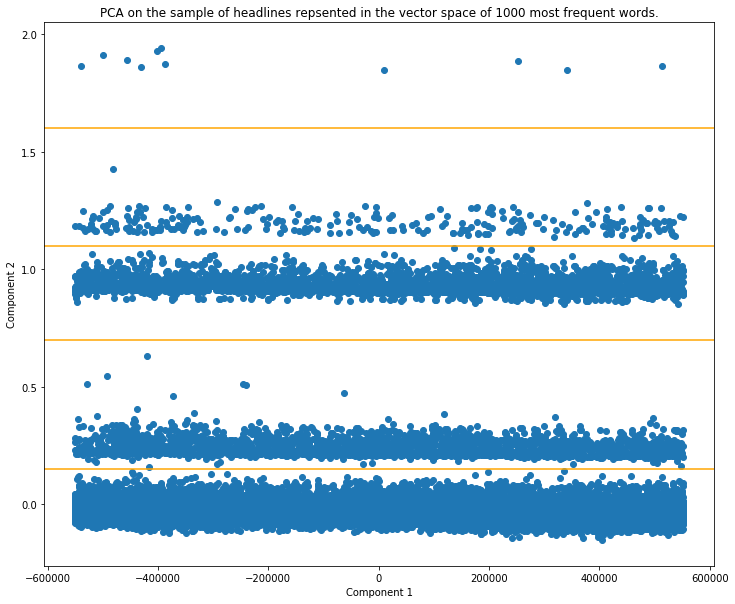

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
plt.scatter(bow_t[:,0], bow_t[:,1])
plt.title('PCA on the sample of headlines repsented in the vector space of 1000 most frequent words.')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.axhline(y=0.15, color='orange')
plt.axhline(y=0.70, color='orange')
plt.axhline(y=1.1, color='orange')
plt.axhline(y=1.6, color='orange')
plt.show()

At this scale we can distiguish 4 main categories, plus outliers.
Let's check the samples in each category. It seems that categories only differ on the y-component. So we use component 2 to filter out.

In [18]:
df.headline_text[bow_samp[bow_t[:,1] > 1.5]['index']].head(15)

953656     police officers car set on fire outside footscray police station
947792     police hunt teens over bottlo hold up police car                
299722     act chief police officer honoured with full police              
1052411    ibac probe uncovers serious police misconduct ballarat police   
542230     police lawyer brent meertens defends the police                 
1009227    police operation at sydney schools a precaution; police say     
38406      police confused over police chase lingo coroner                 
984016     nsw and act police gather to mark police remembrance day        
211554     police chief considers atvs for regional police                 
939325     ferguson reignites after police chief resigns police shot       
1091237    war weapons; police gun handed into act police                  
Name: headline_text, dtype: object

In [19]:
df.headline_text[bow_samp[(bow_t[:,1] > 0.15) & (bow_t[:,1] < 0.70)]['index']].head(15)

488765    man faces court over fake death fraud                         
637096    man charged with murder after fight at party                  
610788    man run over and killed while lying on road                   
246985    houllier the right man for socceroos job cahill               
588581    chinese man joins queensland flood aid effort                 
869806    man injured in crane collapse at melbourne shipping container 
981044    ellenbrook man charged with assault of 7 month old baby       
872243    coffs harbour man refused bail over rape and murder of toddler
74052     man killed in boating accident                                
601911    man who killed neighbour refused parole                       
229505    proteas retain 16 man squad for nz tests                      
289968    griffith man faces charges                                    
36498     man jailed over burning parents house                         
199247    bird flu kills vietnamese man official sa

We get clusters of headlines contanining most frequent words: police, man. 

Let's explore the trends around some topics. Starting with American 2016 elections.

In [16]:
# A priori keywords that refer to 2016 American elections
key_us = ['american', 'america', 'us', 'usa', 'elections', 'polls', 'poll', 'presidency','president', 'candidate', 'trump', 'clinton', 'white', 'house', 'running']
key_for_us = [x for x in most_common_uni.word.tolist() if x in key_us]

In [17]:
#This set can be used as vocabulary to detect headlines refering to US elections
vecto_us = CountVectorizer(vocabulary=key_for_us) 
bow_us= vecto_us.fit_transform(df.headline_text)
bow_us = bow_us.toarray()

In [18]:
bow_samp_us = pd.DataFrame(bow_us)
bow_samp_us['detect_us'] = bow_samp_us[list(range(0,len(key_for_us)))].sum(axis=1)
bow_samp_us = bow_samp_us.sort_values(['detect_us'], ascending=False) # Sorting w.r.t. the matching score

In [19]:
#The headlines matching the most the keywords about american elections. 
pd.set_option('display.max_colwidth', -1) #To view the full headline in preview
df.headline_text.iloc[bow_samp_us.index].head(100)

1051919    donald trump and hillary clinton race to white house            
1051585    trump clinton clash over economy in white house race            
990811     carson ahead of trump in republican white house race poll shows 
1033062    president and vice president barbie in white house bid          
1041689    trump clinton court ohio as white house race heats up           
1058004    trump picks mulvaney to be white house budget director          
1057975    michelle obama says barack bought hope to white house america   
1052781    donald trump loyalists children to steer white house transition 
1068584    donald trump inside while intruder scales white house fence     
960571     donald trump announces run for the white house                  
1095831    donald trump defends twitter tweets key to white house victory  
1032935    white house confirms us vice president will visit australia     
1036386    us election clinton polls surge as trump has temper tantrum     
788580     a

As we can expected, keywords matching scoring may give us some false positives.
Like: 
> 788580     an myanmar president makes historic white house visit

> 177360     german president backs september poll

are not related to American campaign.

We may also have true negative (headlines that are not in this list but still talk about american campaign).

Thus, we could try to build a classifier by annotating by hand some data some of these headlines.
First, let's plot the trends of this topic across time.

In [20]:
# We assume here that keywords matching provides full accuracy, i.e. that we get all the headlines related to US campain.
df['is_us_campaign'] = (bow_samp_us['detect_us'] >= 1).apply(lambda x: int(x))

In [21]:
#Let's group by month the number of headlines related to US campaign
df['year'] = df.publish_date.apply(lambda x: x.year)
df['month'] = df.publish_date.apply(lambda x: x.month)
df['day'] = df.publish_date.apply(lambda x: x.day)

# Function to ease sorting the month/day index: padding with 0 
def pad_str(s):
    if len(s) == 1:
        return '0'+ s
    else:
        return s

df['year_month']= df.publish_date.apply(lambda x: str(x.year) + ' ' + pad_str(str(x.month)))
# timeseries
ts_us = df.groupby(['year_month'])['is_us_campaign'].sum()

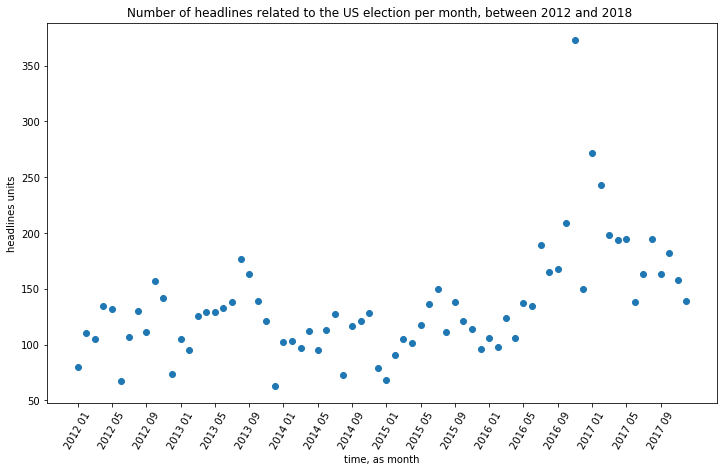

In [22]:
# Let s take into account only the period 2014-2017
ts_us = df[df.publish_date > '2012'].groupby(['year_month'])['is_us_campaign'].sum()
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(ts_us.index, ts_us, 'o')
ax.set_xticklabels(ts_us.index[::4], rotation=60) # Sampling the ticks by 4
ax.set_xticks(ax.get_xticks()[::4]) # Sampling the ticks by 4
plt.title('Number of headlines related to the US election per month, between 2012 and 2018 ')
plt.xlabel('time, as month')
t = plt.ylabel('headlines units')

In [23]:
ts_us.idxmax()

'2016 11'

The peak is in November 2016, as we would expect, month of elections.
Probably the hits in 2012-2013-early 2014 are not related to the campaign but to other countries or to US politics in general.

Let's take the few first headlines we got from keywords matching, and annotate to validate if it is related or not to the us elections. In that way, we are building a training set for classification.

Obama was elected in late 2012. So let's take into account only 2013-2017 period.

In [25]:
#df.iloc[bow_samp_us.index].to_csv('./data/us_campaign.csv')

In [26]:
dftrain = pd.read_csv('./data/us_campaign_100annotated.csv')
dftrain.head(2)

Unnamed: 0 publish_date  \
0  1051919     8/11/16       
1  1051585     5/11/16       

                                          headline_text  is_us_campaign  year  \
0  donald trump and hillary clinton race to white house  1               2016   
1  trump clinton clash over economy in white house race  1               2016   

   month  day year_month  
0  11     8    2016 11    
1  11     5    2016 11

In [27]:
def get_bow_matrix(number_most_common_words=None):
    N = number_most_common_words
    word_vec = most_common_uni.word.iloc[0:N]
    vecto = CountVectorizer(vocabulary=word_vec) 
    bow_= vecto.fit_transform(df.headline_text)
    bow_ = bow_.toarray()
    return bow_

def get_features(df, bow_matrix):
    dfmod = pd.DataFrame(bow_matrix)
    dfmod['month'] = df.month
    dfmod['year'] = df.year
    return dfmod
    

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lreg = LogisticRegression()

# Get the array of features with bag of words 
# Using a vocabulary of the most common words
bow_matrix = get_bow_matrix(100)
dfmod = get_features(df, bow_matrix)

In [32]:
feat_training = dfmod.iloc[dftrain['Unnamed: 0']]
feat_training.head(2)

0  1  2  3  4  5  6  7  8  9  ...   92  93  94  95  96  97  98  99  \
1051919  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0    
1051585  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0    

         month  year  
1051919  11     2016  
1051585  11     2016  

[2 rows x 102 columns]

In [41]:
target_training = dftrain[['is_us_campaign', 'Unnamed: 0']]
target_training.index = target_training['Unnamed: 0']
target_training = target_training['is_us_campaign']
target_training.head()

Unnamed: 0
1051919    1
1051585    1
990811     1
1033062    1
1041689    1
Name: is_us_campaign, dtype: int64

In [68]:
cross_val_score(lreg, feat_training, target_training, cv=5)

array([0.70588235, 0.76470588, 0.625     ])

In [75]:
#Average accuracy on the training set with 3-fold cross-validation: 0.70
np.mean(cross_val_score(lreg, feat_training, target_training, cv=5))

0.6988220551378447

Average accuracy on the training set with 3-fold cross-validation: 0.70

In [80]:
from sklearn.metrics import confusion_matrix
lreg.fit(feat_training, target_training)
target_predicted = lreg.predict(feat_training)
confusion_matrix(target_training, target_predicted)

array([[40, 13],
       [13, 34]])

In [81]:
#Accuracy on the training set
lreg.score(feat_training, target_training)

0.74

In [86]:
false_negative_ind = target_training[(target_predicted != target_training) & target_training==1].index

In [87]:
df.headline_text[false_negative_ind]

Unnamed: 0
1033062    president and vice president barbie in white house bid      
960571     donald trump announces run for the white house              
1022885    donald trump shifts focus towards white house               
1089093    trump aide sebastian gorka the latest to leave white house  
1009359    iowa caucuses trump white house campaign faces first test   
960851     donald trump joins race for the white house                 
1017865    donald trump white house says nuclear policy catastrophic   
216661     white house aides trial set for after us poll               
1023074    white house is not a reality show obama warns trump         
1059743    will president trump be the most pro israel president ever  
972263     donald trump refuses to rule out independent white house run
946421     hillary clinton kicks off white house campaign in iowa      
946252     republican marco rubio starts white house presidency bid    
Name: headline_text, dtype: object

### Comments

1 - Bag of Words (BoW) space and representation.
At this stage, BoW seems to be limited to extract topics. Driven by words frequencies.

2 - Keyword matching is doing well to catch relevant headlines with the simple score (number of keywords hit per headline).

